In [1]:
import pandas as pd
from pathlib import Path
import os
import sys
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../..')

In [3]:
from src.dataloader import cxrDataset, get_dataloader
import src.utils as utils

In [4]:
root = Path('/hpc/group/kamaleswaranlab/EmoryDataset/Images/chest_xrays')

YEARS = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
image_dir = "extracted-images"
metadata = "metadata_with_supertables_filtered_notes_filtered.csv"
notes = "all_notes.csv"

In [5]:
metadatadf = pd.read_csv(root / metadata)

/tmp/ipykernel_2239618/1621597305.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  metadatadf = pd.read_csv(root / metadata)


In [6]:
notesdf = pd.read_csv(root / notes)

/tmp/ipykernel_2239618/3106802520.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  notesdf = pd.read_csv(root / notes)


In [31]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [32]:
dataloader = get_dataloader(
    df=metadatadf.iloc[:1000],
    notesdf=notesdf,
    root_dir=str(root),
    image_dir=str(image_dir),
    transform=transform,
    acc_to_path=utils.acc_to_path,
    batch_size=1,
    max_sequence_length=20
)

/hpc/home/ma618/cxrgen/scratch/notebooks/../../src/dataloader.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StudyDate'] = pd.to_datetime(df['StudyDate'])


In [48]:
for batch_images, batch_mask, batch_notes in dataloader:
    # batch_images shape: [batch_size, seq_length, channels, height, width]
    # batch_metadata contains sequence information and valid_mask
    break

In [19]:
def preprocess_report(report_text: str) -> str:
    # Remove special characters and extra whitespace
    report = report_text.replace('\r', ' ').replace('\n', ' ')
    report = ' '.join(report.split())
    return report

def extract_findings(report_text: str) -> str:
    # Convert to lowercase for case-insensitive matching
    report_lower = report_text.lower()
    
    # Look for either "findings" or "impression" (with or without a slash)
    start_markers = ["impression:", "findings/impression:", "impression/findings:"]
    
    # Find the start of the findings section
    start_idx = -1
    for marker in start_markers:
        if marker in report_lower:
            start_idx = report_lower.find(marker)
            break
    
    if start_idx == -1:
        return ""  # No findings/impressions section found
    
    # Get the text after the marker
    findings_text = report_lower[start_idx:]
    
    # Find the next section if it exists (marked by a newline and uppercase word)
    sections = findings_text.split('\n')
    cleaned_sections = []
    print(findings_text)
    for section in sections:
        # If we find a new all-caps section header, stop
        if section.strip().isupper() and len(section.strip()) > 0:
            break
        cleaned_sections.append(section)
    print(sections)
    # Join the relevant sections and clean up
    findings = ' '.join(cleaned_sections)
    
    # Remove the "FINDINGS:" or "IMPRESSION:" header
    for marker in start_markers:
        findings = findings.lower().replace(marker, "", 1)
    
    # Clean up extra whitespace and special characters
    findings = findings.replace('\r', ' ').replace('\n', ' ')
    findings = ' '.join(findings.split())
    
    return findings.strip()

In [49]:
batch_notes[0][1]

'REPORT\r\rXR Chest 1 View Portable\n\nCLINICAL INDICATION: Other;PICC LINE TIP VERIFICATION PLEASE. THANK YOU \n\nCOMPARISON: 5/15/2015\n\nFINDINGS/\nIMPRESSION: New right PICC line tip is in the right atrium. 2 right-sided chest\ntubes are unchanged. Diffuse interstitial thickening likely represents pulmonary\nedema. Right small hydropneumothorax effusion and trace left effusion are\nunchanged.\n'

In [50]:
impression = extract_findings(batch_notes[0][1])

impression: new right picc line tip is in the right atrium. 2 right-sided chest
tubes are unchanged. diffuse interstitial thickening likely represents pulmonary
edema. right small hydropneumothorax effusion and trace left effusion are
unchanged.

['impression: new right picc line tip is in the right atrium. 2 right-sided chest', 'tubes are unchanged. diffuse interstitial thickening likely represents pulmonary', 'edema. right small hydropneumothorax effusion and trace left effusion are', 'unchanged.', '']


In [51]:
impression

'new right picc line tip is in the right atrium. 2 right-sided chest tubes are unchanged. diffuse interstitial thickening likely represents pulmonary edema. right small hydropneumothorax effusion and trace left effusion are unchanged.'

In [13]:
from diffusers import StableDiffusionPipeline
import torch

/hpc/home/ma618/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

In [23]:
model_path = "/hpc/group/kamaleswaranlab/cxrgen/roentgen/roentgen"
device='cuda'  # or mps, cpu...

pipe = StableDiffusionPipeline.from_pretrained(model_path).to(torch.float32).to(device)

prompt = impression
print(prompt)

output = pipe([prompt], num_inference_steps=70, height=512, width=512, guidance_scale=4)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...:  14%|█▍        | 1/7 [00:09<00:54,  9.13s/it]/hpc/home/ma618/.local/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...:  29%|██▊       | 2/7 [00:09<00:19,  3.84s/it]An error occurred while trying to fetch /hpc/group/kamaleswaranlab/cxrgen/roentgen/roentgen/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /hpc/group/kamaleswaranlab/cxrgen/roentgen/roentgen/vae.
Defaulting to unsafe serialization. Pass `a

postoperative changes. low lung volumes with bibasilar atelectasis.


100%|██████████| 70/70 [00:13<00:00,  5.15it/s]


In [52]:
prompt = impression
print(prompt)

output = pipe([prompt], num_inference_steps=70, height=512, width=512, guidance_scale=4)

new right picc line tip is in the right atrium. 2 right-sided chest tubes are unchanged. diffuse interstitial thickening likely represents pulmonary edema. right small hydropneumothorax effusion and trace left effusion are unchanged.


100%|██████████| 70/70 [00:05<00:00, 12.80it/s]


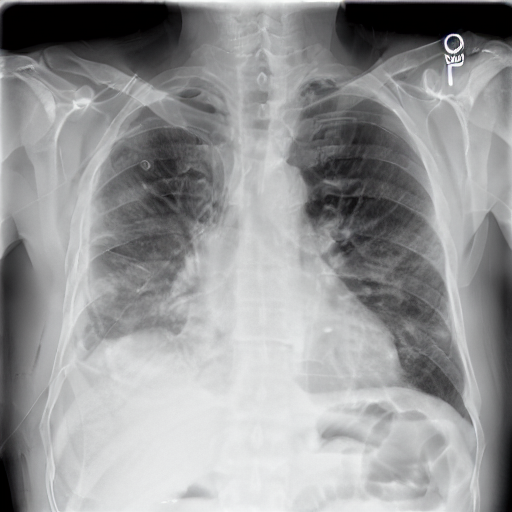

In [53]:
output.images[0]

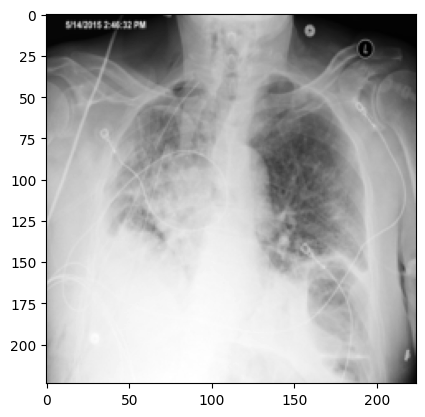

In [54]:
plt.imshow(batch_images[0,0,1,:,:], cmap = 'grey')
plt.show()

In [15]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer, CLIPVisionModel
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

In [16]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [21]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
).to('cuda')

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to('cuda'))[0]